## Used car value prediction using Machine Learning
---
[Sarinder Virk](Sarinder.virk@sjsu.edu)<br>
[Rajat banerjee](rajat.banerjee@sjsu.edu)<br>

## Abstract

In the used car market, millions of used vehicles are sold across US and the world each year. A copmprehensive pricing analysis will helps, both the consumer as we as the business to make an informed decision.
Thus we need a data modelt hat can predict what the price of a car would be based on the features and attributes whihc suites the consumer.

## Objective

The objective of this notebook is to historical sales information of used cars and come up with a ML model, which can take car attributes as an input and poredict to a hihg degree of accuracy, what the value of the said vechicle should be

## Import Libraries

In [26]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [28]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


## Import Dataset

### The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


#### Get the data
First download and import the dataset using pandas:

In [29]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [30]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Car Sales dataset
Dataset Used: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

In [31]:
from google.colab import output
output.enable_custom_widget_manager()

In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
raw_dataset2 = pd.read_csv('/content/drive/Shareddrives/Runtimeterror/255/Sarinder + Rajat/vehicles.csv')

Mounted at /content/drive


In [33]:
df_vehicles = raw_dataset2.copy()

## Data Cleanup / Preprocessing

### Clean the data

#### AutoMPG Data

In [34]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [35]:
dataset = dataset.dropna()

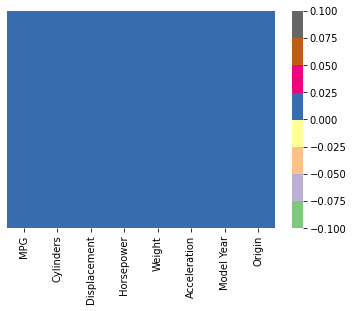

In [36]:
sns.heatmap(dataset.isnull(),yticklabels=False,cbar=True,cmap='Accent')

#### Vehicle Sales Data

In [37]:
df_vehicles.isna().sum()


id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

Removing columns whihc are not needed

In [38]:

df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles.fuel != 'gas'].index)
df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles.title_status != 'clean'].index)
df_vehicles = df_vehicles.drop(columns=['fuel', 'title_status', 'id', 'url', 'region', 'region_url', 'cylinders', 'model', 'size', 'image_url', 'description', 'county', 'lat', 'long', 'posting_date', 'transmission', 'VIN', 'drive', 'type', 'paint_color', 'state'])

In [39]:
df_vehicles = df_vehicles.dropna()

In [40]:
df_vehicles.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,190065.0,58709.704059,1.213624e+07,0.0,5995.0,12750.0,24990.0,3.736929e+09
year,190065.0,2010.358704,9.900458e+00,1900.0,2007.0,2013.0,2017.0,2.022000e+03
odometer,190065.0,99536.848157,2.050707e+05,0.0,37993.0,91036.0,139000.0,1.000000e+07


#### Eliminate outliers

In [41]:
df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles.odometer > 350000].index)
df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles.odometer < 35].index)
df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles.price > 50000].index)
df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles.price < 1000].index)
df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles.year < 1990].index)
df_vehicles.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,169608.0,16637.219070,11608.557556,1000.0,6900.0,13900.0,24995.00,50000.0
year,169608.0,2011.602884,6.043370,1990.0,2008.0,2013.0,2017.00,2022.0
odometer,169608.0,96491.255477,63378.444623,36.0,39859.0,94128.5,140811.75,350000.0


year
1990.0    AxesSubplot(0.125,0.125;0.775x0.755)
1991.0    AxesSubplot(0.125,0.125;0.775x0.755)
1992.0    AxesSubplot(0.125,0.125;0.775x0.755)
1993.0    AxesSubplot(0.125,0.125;0.775x0.755)
1994.0    AxesSubplot(0.125,0.125;0.775x0.755)
1995.0    AxesSubplot(0.125,0.125;0.775x0.755)
1996.0    AxesSubplot(0.125,0.125;0.775x0.755)
1997.0    AxesSubplot(0.125,0.125;0.775x0.755)
1998.0    AxesSubplot(0.125,0.125;0.775x0.755)
1999.0    AxesSubplot(0.125,0.125;0.775x0.755)
2000.0    AxesSubplot(0.125,0.125;0.775x0.755)
2001.0    AxesSubplot(0.125,0.125;0.775x0.755)
2002.0    AxesSubplot(0.125,0.125;0.775x0.755)
2003.0    AxesSubplot(0.125,0.125;0.775x0.755)
2004.0    AxesSubplot(0.125,0.125;0.775x0.755)
2005.0    AxesSubplot(0.125,0.125;0.775x0.755)
2006.0    AxesSubplot(0.125,0.125;0.775x0.755)
2007.0    AxesSubplot(0.125,0.125;0.775x0.755)
2008.0    AxesSubplot(0.125,0.125;0.775x0.755)
2009.0    AxesSubplot(0.125,0.125;0.775x0.755)
2010.0    AxesSubplot(0.125,0.125;0.775x0.755)
2011.0  

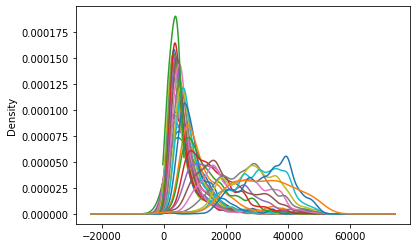

In [42]:
df_vehicles.groupby('year').price.plot(kind='kde')

#### TEMP CODE - [TODO : REMOVE]

In [43]:
# TODO - dropping these for now, don't really do this
df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles.manufacturer != 'toyota'].index)
df_vehicles = df_vehicles.drop(columns=['manufacturer'])
df_vehicles

,price,year,condition,odometer
30,30990,2017.0,good,41124.0
34,35000,2019.0,excellent,43000.0
67,31990,2013.0,good,55068.0
70,22990,2012.0,good,37725.0
80,29990,2012.0,good,43182.0
...,...,...,...,...
426720,19200,2013.0,good,90000.0
426733,15990,2015.0,good,42121.0
426782,23995,2013.0,good,114215.0
426857,41990,2019.0,good,36630.0


#### Encode Category Data

The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

Note: You can set up the `tf.keras.Model` to do this kind of transformation for you but that's beyond the scope of this tutorial. Check out the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) or [Load CSV data](../load_data/csv.ipynb) tutorials for examples.

In [44]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [45]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [46]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

one_hot_df = encode_and_bind(df_vehicles, 'condition')
# one_hot_df = encode_and_bind(one_hot_df, 'state')
one_hot_df

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage
30,30990,2017.0,41124.0,0,0,1,0,0,0
34,35000,2019.0,43000.0,1,0,0,0,0,0
67,31990,2013.0,55068.0,0,0,1,0,0,0
70,22990,2012.0,37725.0,0,0,1,0,0,0
80,29990,2012.0,43182.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
426720,19200,2013.0,90000.0,0,0,1,0,0,0
426733,15990,2015.0,42121.0,0,0,1,0,0,0
426782,23995,2013.0,114215.0,0,0,1,0,0,0
426857,41990,2019.0,36630.0,0,0,1,0,0,0


### Saving Clean file

In [47]:
dataset.to_csv('./auto_mpfg_cleaned.csv',index=False)

In [48]:
one_hot_df.to_csv('./vehicles_data_clean.csv',index=False)

## Initial Analysis

In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [148]:
df_final = pd.read_csv('/content/drive/Shareddrives/Runtimeterror/255/Sarinder + Rajat/vehiclesFinal.csv')

In [149]:
df_final['year']=df_final['year'].astype('int64')
df_final.drop(['lat','long','id'],axis=1,inplace=True)
df_final.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,price
0,mohave county,2012,jeep,patriot,like new,4 cylinders,gas,247071.0,clean,automatic,4wd,full-size,offroad,silver,3495
1,oregon coast,2014,bmw,328i m-sport,good,5 cylinders,gas,76237.0,clean,automatic,rwd,full-size,sedan,grey,13750
2,greenville / upstate,2001,dodge,caravan,excellent,6 cylinders,gas,199000.0,clean,automatic,4wd,full-size,offroad,grey,2300
3,mohave county,2004,chevrolet,colorado ls,excellent,5 cylinders,gas,54000.0,clean,automatic,rwd,mid-size,pickup,red,9000
4,maine,2005,ford,mustang convertible,excellent,6 cylinders,gas,62800.0,clean,automatic,rwd,mid-size,convertible,silver,8500


In [152]:
df_final.shape

(374222, 15)

In [153]:
df_final.columns

Index(['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'price'],
      dtype='object')

#### Pair plot

<Figure size 1440x720 with 0 Axes>

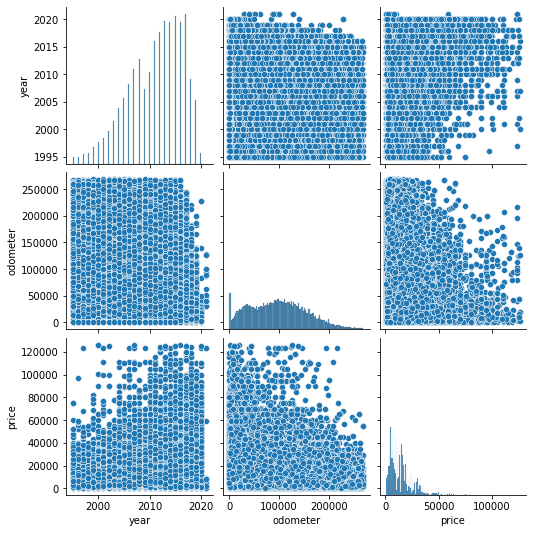

In [169]:
plt.figure(figsize=(20,10))
sns.pairplot(df_final)
plt.show()

### Price : Distribution Plot

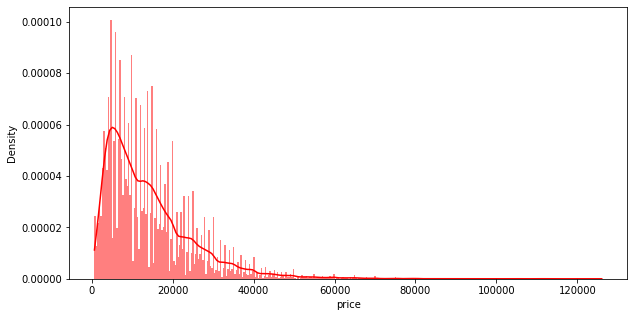

In [168]:
plt.figure(figsize=(10,5))
sns.histplot(df_final.price, color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
plt.show()

### Fuel type vs Price

<Figure size 720x360 with 0 Axes>

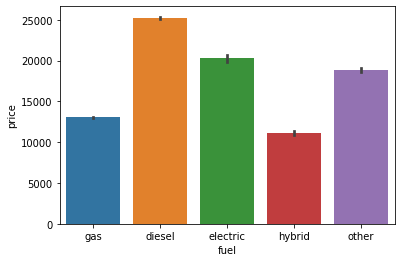

In [167]:
plt.figure(figsize=(10,5))
fig,axs=plt.subplots()
p1=sns.barplot(x='fuel',y='price',data=df_final,ax=axs)
plt.show()

### Vehicle condition VS Price

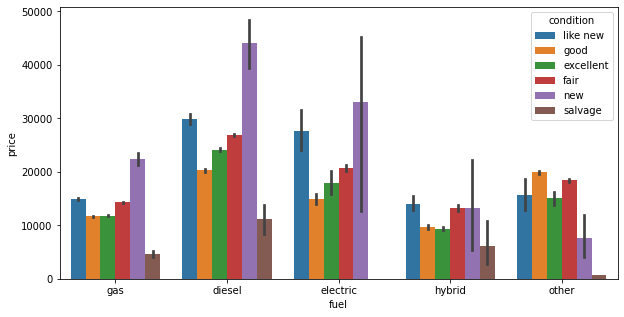

In [165]:
plt.figure(figsize=(10,5))
sns.barplot(x='fuel',y='price',hue='condition',data=df_final)
plt.show()

### Vehicle Type vs Price

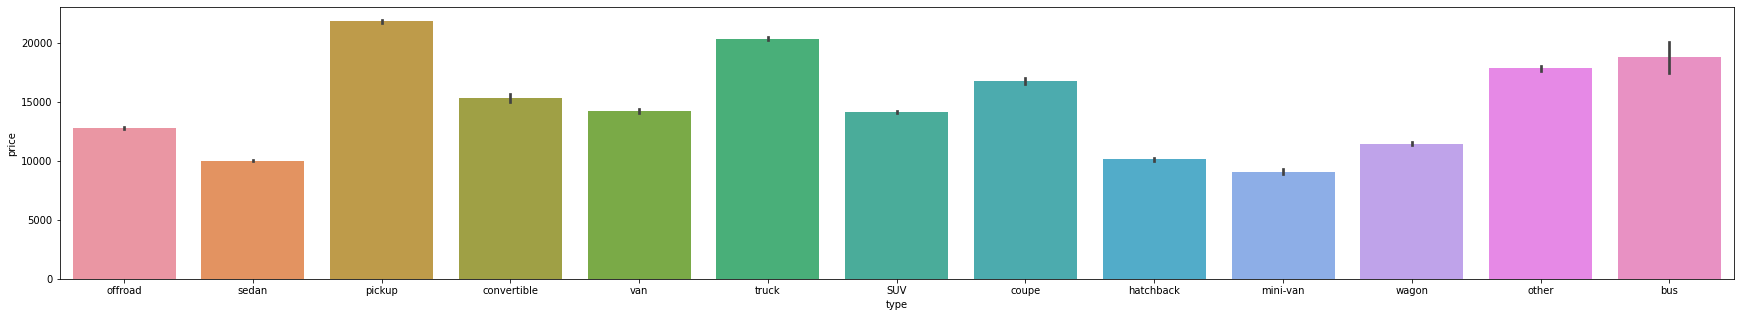

In [176]:
plt.figure(figsize=(30,5))
sns.barplot(x='type',y='price',data=df_final)
plt.show()

### Manufacturer VS Price

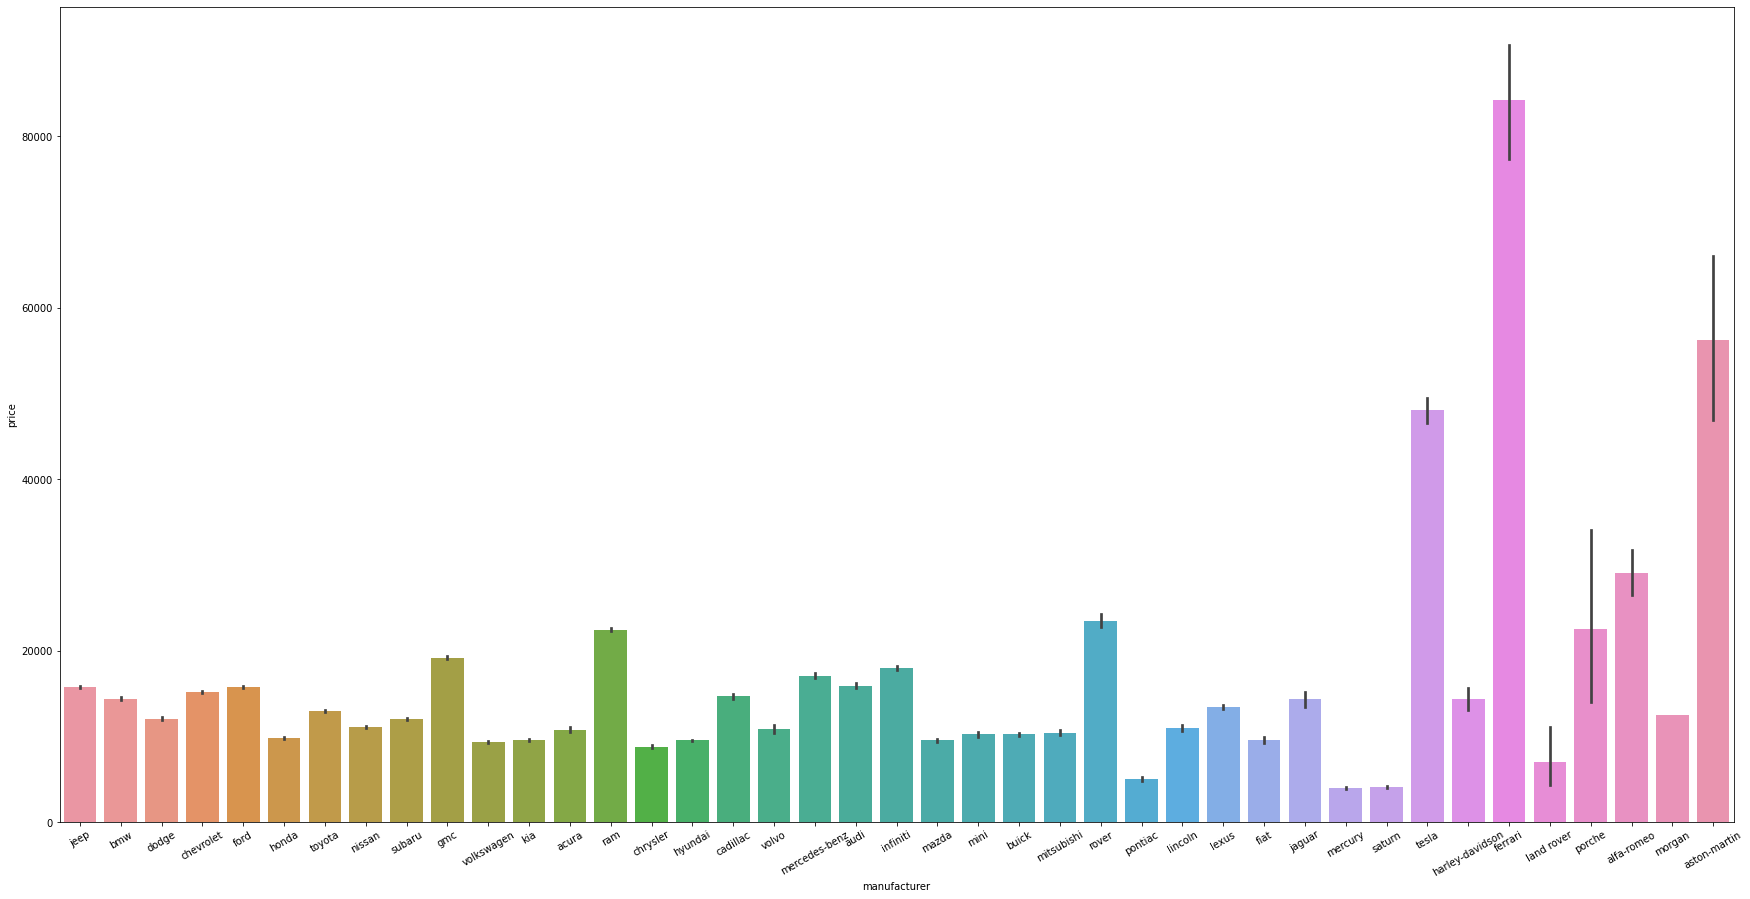

In [186]:
plt.figure(figsize=(30,15))

sns.barplot(x='manufacturer',y='price',data=df_final)
plt.xticks(rotation=30)
plt.show()

## Train Test Split

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [49]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [50]:
train_dataset2 = one_hot_df.sample(frac=0.8, random_state=0)
test_dataset2 = one_hot_df.drop(train_dataset2.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

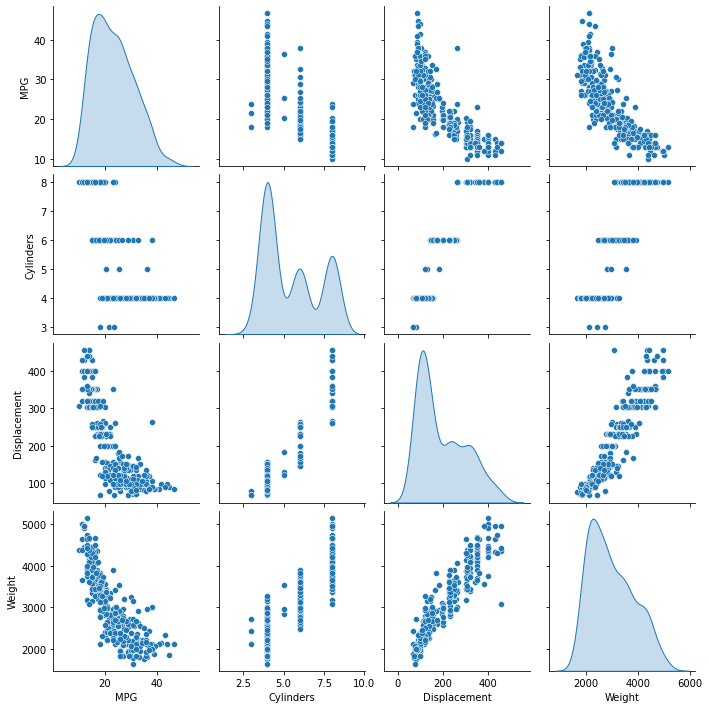

In [51]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

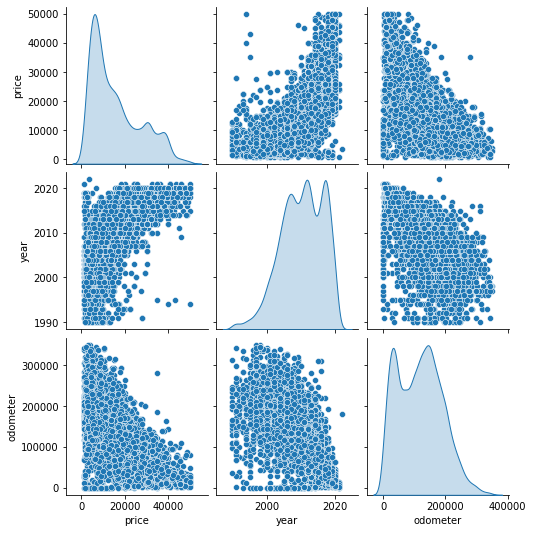

In [52]:
sns.pairplot(train_dataset2[['price', 'year', 'odometer']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

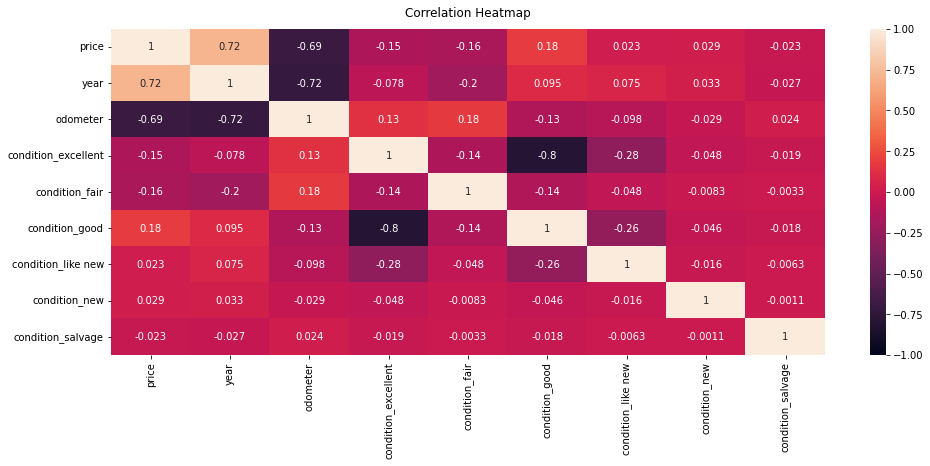

In [53]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(train_dataset2.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [54]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [55]:
train_dataset2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,11615.0,15642.501593,11373.611769,1000.0,6400.0,11999.0,22990.0,50000.0
year,11615.0,2010.211279,6.168976,1990.0,2006.0,2011.0,2015.0,2022.0
odometer,11615.0,117474.050969,70798.127384,90.0,55034.0,118885.0,168000.0,350000.0
condition_excellent,11615.0,0.456134,0.498094,0.0,0.0,0.0,1.0,1.0
condition_fair,11615.0,0.024279,0.153921,0.0,0.0,0.0,0.0,1.0
condition_good,11615.0,0.432544,0.495450,0.0,0.0,0.0,1.0,1.0
condition_like new,11615.0,0.083857,0.277185,0.0,0.0,0.0,0.0,1.0
condition_new,11615.0,0.002755,0.052419,0.0,0.0,0.0,0.0,1.0
condition_salvage,11615.0,0.000430,0.020744,0.0,0.0,0.0,0.0,1.0


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [56]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [57]:
train_features2 = train_dataset2.copy()
test_features2 = test_dataset2.copy()

train_labels2 = train_features2.pop('price')
test_labels2 = test_features2.pop('price')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [58]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [59]:
train_dataset2.describe().transpose()[['mean', 'std']]

,mean,std
price,15642.501593,11373.611769
year,2010.211279,6.168976
odometer,117474.050969,70798.127384
condition_excellent,0.456134,0.498094
condition_fair,0.024279,0.153921
condition_good,0.432544,0.495450
condition_like new,0.083857,0.277185
condition_new,0.002755,0.052419
condition_salvage,0.000430,0.020744


### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [60]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [61]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [62]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [63]:
normalizer2 = tf.keras.layers.Normalization(axis=-1)
normalizer2.adapt(np.array(train_features2))
print(normalizer2.mean.numpy())

[[  2010.212 117474.05       0.456      0.024      0.433      0.084
       0.003      0.   ]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [64]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [65]:
first2 = np.array(train_features2[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first2)
  print()
  print('Normalized:', normalizer2(first2).numpy())

First example: [[ 2015. 71104.     0.     0.     1.     0.     0.     0.]]

Normalized: [[ 0.78 -0.65 -0.92 -0.16  1.15 -0.3  -0.05 -0.02]]


In [66]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

In [67]:
train_labels2

52202     18495
122321    21995
32741      3900
95991      4400
77584      6000
          ...  
89754     36590
137117    16995
304153     6500
272037     6000
14964      9995
Name: price, Length: 11615, dtype: int64

## Model Implementations

### Linear regression

#### Linear regression with one variable

Begin with a single-variable linear regression to predict `'MPG'` from `'Horsepower'`.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in your single-variable linear regression model:

- Normalize the `'Horsepower'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'Horsepower'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `horsepower` data:

In [74]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [75]:
odometer = np.array(train_features2['odometer'])

odometer_normalizer = layers.Normalization(input_shape=[1,], axis=None)
odometer_normalizer.adapt(odometer)

Build the Keras Sequential model:

In [76]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [77]:
odometer_model = tf.keras.Sequential([
    odometer_normalizer,
    layers.Dense(units=1)
])

odometer_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `'MPG'` from `'Horsepower'`.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [78]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 53ms/step


array([[-0.993],
       [-0.561],
       [ 1.833],
       [-1.392],
       [-1.259],
       [-0.494],
       [-1.492],
       [-1.259],
       [-0.328],
       [-0.561]], dtype=float32)

In [79]:
odometer_model.predict(odometer[:10])

1/1 [==============================] - 0s 50ms/step


array([[-0.455],
       [-0.025],
       [ 0.598],
       [ 0.348],
       [ 1.03 ],
       [-0.574],
       [-0.402],
       [ 0.589],
       [-1.027],
       [-1.004]], dtype=float32)

Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

In [80]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [81]:
odometer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras `Model.fit` to execute the training for 100 epochs:

In [82]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.88 s, sys: 162 ms, total: 4.04 s
Wall time: 3.96 s


In [83]:
%%time
history2 = odometer_model.fit(
    train_features2['odometer'],
    train_labels2,
    epochs=100,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
291/291 [==============================] - 1s 3ms/step - loss: 15667.3574 - val_loss: 15456.1270
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 15638.2588 - val_loss: 15427.0410
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 15609.1523 - val_loss: 15397.9492
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 15580.0586 - val_loss: 15368.8623
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 15550.9512 - val_loss: 15339.7705
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 15521.8477 - val_loss: 15310.6875
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 15492.7354 - val_loss: 15281.5977
Epoch 8/100
291/291 [==============================] - 1s 2ms/step - loss: 15463.6436 - val_loss: 15252.5049
Epoch 9/100
291/291 [==============================] - 1s 2ms/step - loss: 15434.5312 - val_loss: 15223.4092
Epoch 10/100
291/29

Visualize the model's training progress using the stats stored in the `history` object:

In [84]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802071,4.190083,95
96,3.804694,4.184915,96
97,3.805526,4.173742,97
98,3.804695,4.199116,98
99,3.802295,4.195011,99


In [85]:
hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
hist2.tail()

,loss,val_loss,epoch
95,12962.233398,12753.550781,95
96,12934.968750,12726.239258,96
97,12907.709961,12698.925781,97
98,12880.430664,12671.717773,98
99,12853.182617,12644.482422,99


In [86]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

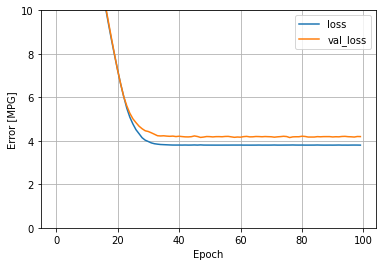

In [87]:
plot_loss(history)

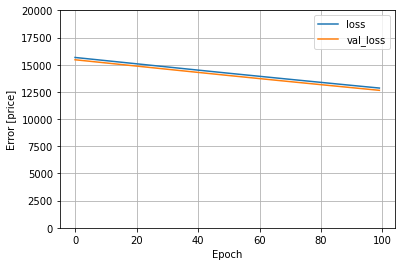

In [88]:
def plot_loss2(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 20000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [price]')
  plt.legend()
  plt.grid(True)

plot_loss2(history2)

Collect the results on the test set for later:

In [89]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [90]:
test_results2 = {}

test_results2['odometer_model'] = odometer_model.evaluate(
    test_features2['odometer'],
    test_labels2, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [91]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [92]:
x2 = tf.linspace(0.0, 251000, 251000)
y2 = odometer_model.predict(x2)

7844/7844 [==============================] - 10s 1ms/step


In [93]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

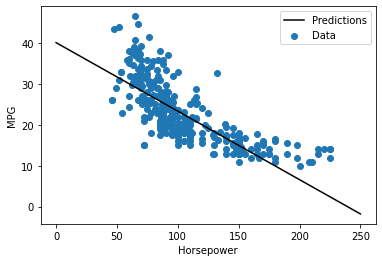

In [94]:
plot_horsepower(x, y)

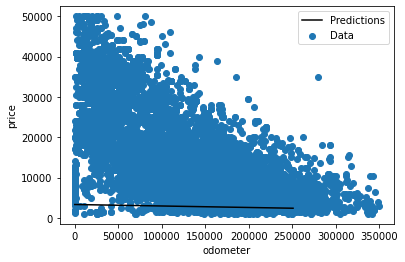

In [95]:
def plot_odometer(x, y):
  plt.scatter(train_features2['odometer'], train_labels2, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('odometer')
  plt.ylabel('price')
  plt.legend()

plot_odometer(x2, y2)

#### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [103]:
linear_model = tf.keras.Sequential([
    normalizer2,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [104]:
linear_model.predict(train_features2[:10])

1/1 [==============================] - 0s 48ms/step


array([[ 0.002],
       [-1.224],
       [ 1.489],
       [-0.511],
       [ 1.289],
       [-0.784],
       [-0.011],
       [ 0.76 ],
       [-1.734],
       [-0.498]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [105]:
linear_model.layers[1].kernel

<tf.Variable 'dense_4/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[-0.796],
       [-0.183],
       [ 0.273],
       [ 0.113],
       [ 0.741],
       [ 0.106],
       [ 0.734],
       [ 0.461]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [106]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=10),
    loss='mean_absolute_error')

In [100]:
%%time
history = linear_model.fit(
    train_features2,
    train_labels2,
    epochs=100,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
291/291 [==============================] - 1s 3ms/step - loss: 14254.5371 - val_loss: 12649.8125
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 11505.3486 - val_loss: 9996.2041
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 9068.6260 - val_loss: 7838.7104
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 7371.5000 - val_loss: 6623.7554
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 6545.0098 - val_loss: 6146.4062
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 6216.5732 - val_loss: 5949.2964
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 6070.8955 - val_loss: 5870.6841
Epoch 8/100
291/291 [==============================] - 1s 2ms/step - loss: 5997.0537 - val_loss: 5836.7349
Epoch 9/100
291/291 [==============================] - 1s 2ms/step - loss: 5963.4209 - val_loss: 5828.9214
Epoch 10/100
291/291 [============

Using all the inputs in this regression model achieves a much lower training and validation error than the `horsepower_model`, which had one input:

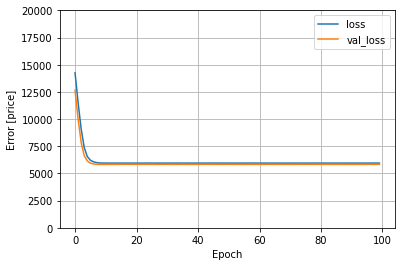

In [101]:
plot_loss2(history)

Collect the results on the test set for later:

In [102]:
test_results2['linear_model'] = linear_model.evaluate(
    test_features2, test_labels2, verbose=1)

91/91 [==============================] - 0s 1ms/step - loss: 5923.7417


### XGBoost regression

In [107]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#model = xgb.XGBRegressor(n_estimators=20, max_depth=800, tree_method="gpu_hist", single_precision_histogram=True)
model = xgb.XGBRegressor(n_estimators=40, max_depth=800, single_precision_histogram=True)
model.fit(train_features2, train_labels2)
train_preds2 = model.predict(train_features2)
val_preds2 = model.predict(test_features2)
error_train = mean_squared_error(train_labels2, train_preds2, squared=False)
error_val = mean_squared_error(test_labels2, val_preds2, squared=False)
print("RMS_error_train = {:.2f} ** RMS_error_val = {:.2f}".format(error_train,error_val))

[02:00:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMS_error_train = 1636.34 ** RMS_error_val = 5238.73


### Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

In [108]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

#### Regression using a DNN and a single input

Create a DNN model with only `'Horsepower'` as input and `horsepower_normalizer` (defined earlier) as the normalization layer:

In [109]:
dnn_odometer_model = build_and_compile_model(odometer_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [110]:
dnn_odometer_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                128       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                      

Train the model with Keras `Model.fit`:

In [111]:
%%time
history = dnn_odometer_model.fit(
    train_features2['odometer'],
    train_labels2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
291/291 [==============================] - 2s 4ms/step - loss: 6707.3145 - val_loss: 5901.3652
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 6099.6938 - val_loss: 6244.2603
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 6098.0889 - val_loss: 6364.0552
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 6038.7300 - val_loss: 5844.0615
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 6090.5205 - val_loss: 6121.3145
Epoch 6/100
291/291 [==============================] - 1s 4ms/step - loss: 6059.6104 - val_loss: 5866.0791
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 6113.1919 - val_loss: 6262.8018
Epoch 8/100
291/291 [==============================] - 1s 3ms/step - loss: 6133.1348 - val_loss: 5845.8164
Epoch 9/100
291/291 [==============================] - 1s 3ms/step - loss: 6058.2500 - val_loss: 5889.7661
Epoch 10/100
291/291 [===============

This model does slightly better than the linear single-input `horsepower_model`:

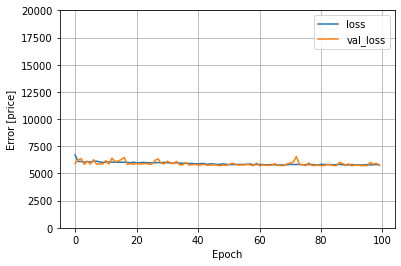

In [112]:
plot_loss2(history)

If you plot the predictions as a function of `'Horsepower'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [113]:
x = tf.linspace(0.0, 250000, 251000)
y = dnn_odometer_model.predict(x)

7844/7844 [==============================] - 13s 2ms/step


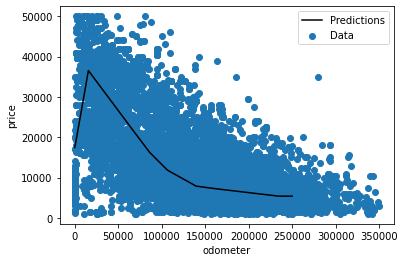

In [114]:
plot_odometer(x, y)

Collect the results on the test set for later:

In [115]:
test_results2['dnn_odometer_model'] = dnn_odometer_model.evaluate(
    test_features2['odometer'], test_labels2,
    verbose=0)

#### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [116]:
dnn_model = build_and_compile_model(normalizer2)
dnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_13 (Dense)            (None, 64)                576       
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                      

In [117]:
%%time
history = dnn_model.fit(
    train_features2,
    train_labels2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
291/291 [==============================] - 2s 4ms/step - loss: 5870.4634 - val_loss: 5054.8970
Epoch 2/100
291/291 [==============================] - 1s 4ms/step - loss: 5206.7910 - val_loss: 4969.4121
Epoch 3/100
291/291 [==============================] - 1s 4ms/step - loss: 5225.8110 - val_loss: 5322.0264
Epoch 4/100
291/291 [==============================] - 1s 4ms/step - loss: 5188.4072 - val_loss: 5197.3062
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 5218.9233 - val_loss: 4942.9912
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 5139.4619 - val_loss: 5160.4058
Epoch 7/100
291/291 [==============================] - 1s 4ms/step - loss: 5158.6138 - val_loss: 5051.8354
Epoch 8/100
291/291 [==============================] - 1s 4ms/step - loss: 5083.3403 - val_loss: 5325.6055
Epoch 9/100
291/291 [==============================] - 1s 4ms/step - loss: 5166.7686 - val_loss: 4990.8159
Epoch 10/100
291/291 [===============

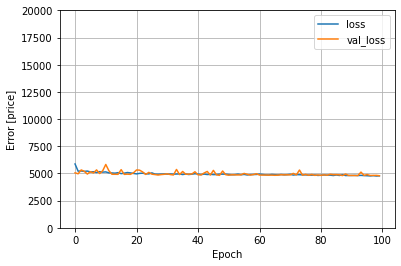

In [118]:
plot_loss2(history)

Collect the results on the test set:

In [119]:
test_results2['dnn_model'] = dnn_model.evaluate(test_features2, test_labels2, verbose=0)

### Decision Tree Regression

In [120]:
# Fitting Decision Tree Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
dtree_regressor = DecisionTreedtree_Regressor()
dtree_regressor.fit(train_features2, train_labels2)

y_pred = dtree_regressor.predict(test_features2)

df = pd.DataFrame({'Real Values':test_labels2, 'Predicted Values':y_pred})
df

,Real Values,Predicted Values
30,30990,30990.0
332,15000,5999.0
534,7200,4495.0
647,8500,6500.0
657,22990,22990.0
...,...,...
425754,29990,29990.0
426168,3995,8900.0
426244,5500,9800.0
426503,32495,32495.0


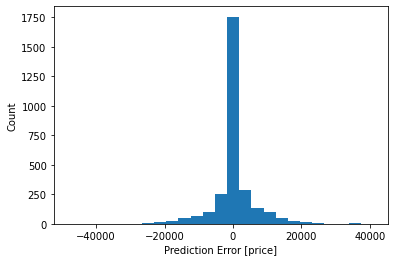

In [121]:
error = y_pred - test_labels2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [price]')
_ = plt.ylabel('Count')

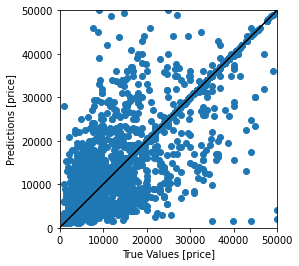

In [122]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels2, y_pred)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='k')

In [123]:
np.mean(error)

388.1760210615066

In [124]:
ypred = dtree_regressor.predict(test_features2)
ypred

array([30990.,  5999.,  4495., ...,  9800., 32495., 10222.])

In [125]:
test_labels2.to_numpy()

array([30990, 15000,  7200, ...,  5500, 32495, 23995])

MSE:  39083499.35429205
RMSE:  6251.679722625916


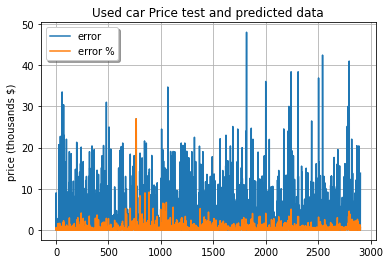

In [126]:
mse = mean_squared_error(test_labels2.to_numpy(), ypred)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

x_ax = range(len(test_labels2.to_numpy()))
#plt.plot(x_ax, test_labels2.to_numpy(), label="original")
#plt.plot(x_ax, ypred, label="predicted")
plt.plot(x_ax, np.absolute(ypred-test_labels2.to_numpy())/1000, label="error")
plt.plot(x_ax, np.absolute(ypred-test_labels2.to_numpy())/test_labels2.to_numpy(), label="error %")
plt.title("Used car Price test and predicted data")
plt.ylabel('price (thousands $)')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### KNN Model

In [127]:
for k in range(1,10):
  from sklearn.neighbors import KNeighborsRegressor

  # Instance and fit
  knn_model = KNeighborsRegressor(n_neighbors=k).fit(train_features2, train_labels2)

  # Score
  score_knn = knn_model.score(test_features2, test_labels2)
  print(k, score_knn)

1 0.6492397689050471
2 0.6909933766296813
3 0.6994439460922909
4 0.6994154641443844
5 0.6947907777774166
6 0.6885175034367067
7 0.6819453668824109
8 0.6778535624669062
9 0.6742202169568507


In [128]:
  knn_model = KNeighborsRegressor(n_neighbors=3).fit(train_features2, train_labels2)

In [129]:
# Predictions
preds = knn_model.predict(test_features2)

# Performance
performance = pd.DataFrame({ 'True Value': test_labels2,
                            'Prediction': preds,
                            'Error': test_labels2 - preds})
# View
performance

,True Value,Prediction,Error
30,30990,30990.000000,0.000000
332,15000,8493.333333,6506.666667
534,7200,3765.000000,3435.000000
647,8500,7731.666667,768.333333
657,22990,22990.000000,0.000000
...,...,...,...
425754,29990,29990.000000,0.000000
426168,3995,7566.333333,-3571.333333
426244,5500,9895.333333,-4395.333333
426503,32495,32495.000000,0.000000


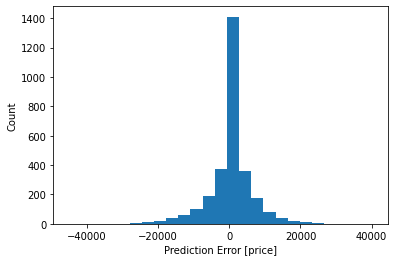

In [130]:
error = preds - test_labels2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [price]')
_ = plt.ylabel('Count')

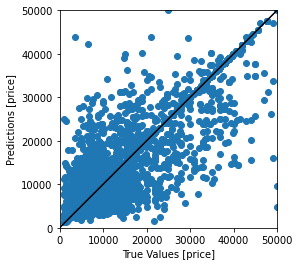

In [131]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels2, preds)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='k')

In [132]:
mean_err = test_labels2 - preds
np.mean(mean_err)

-259.1695362718091

MSE:  38444354.4125727
RMSE:  6200.351152360058


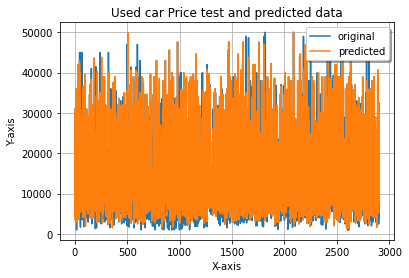

In [133]:
mse = mean_squared_error(test_labels2.to_numpy(), preds)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

x_ax = range(len(test_labels2.to_numpy()))
plt.plot(x_ax, test_labels2.to_numpy(), label="original")
plt.plot(x_ax, preds, label="predicted")
plt.title("Used car Price test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [134]:
pd.DataFrame(test_results2, index=['Mean absolute error [price]']).T

,Mean absolute error [price]
odometer_model,12452.910156
linear_model,5923.741699
dnn_odometer_model,5852.132324
dnn_model,4666.538086


In [135]:
knn_model

KNeighborsRegressor(n_neighbors=3)

## Performance of the ML models

In [136]:
pd.DataFrame(test_results2, index=['Mean absolute error [price]']).T

,Mean absolute error [price]
odometer_model,12452.910156
linear_model,5923.741699
dnn_odometer_model,5852.132324
dnn_model,4666.538086


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

91/91 [==============================] - 0s 2ms/step


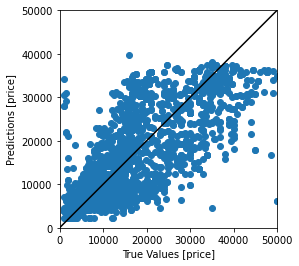

In [137]:
test_predictions2 = dnn_model.predict(test_features2).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels2, test_predictions2)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='k')


It appears that the model predicts reasonably well.

Now, check the error distribution:

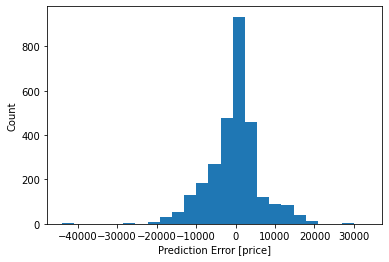

In [138]:
error = test_predictions2 - test_labels2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [price]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [139]:
dnn_model.save('/content/drive/Shareddrives/Runtimeterror/255/Sarinder + Rajat/dnn_model2')

If you reload the model, it gives identical output:

In [140]:
reloaded = tf.keras.models.load_model('/content/drive/Shareddrives/Runtimeterror/255/Sarinder + Rajat/dnn_model2')

test_results2['reloaded'] = reloaded.evaluate(
    test_features2, test_labels2, verbose=0)

In [141]:
pd.DataFrame(test_results2, index=['Mean absolute error [price]']).T

,Mean absolute error [price]
odometer_model,12452.910156
linear_model,5923.741699
dnn_odometer_model,5852.132324
dnn_model,4666.538086
reloaded,4666.538086


MSE:  43965503.90671889
RMSE:  6630.6488299953635


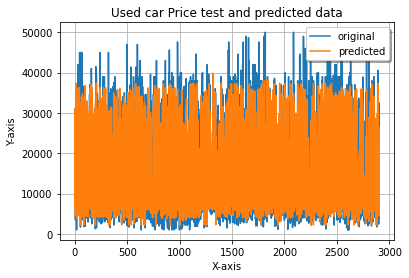

In [142]:
mse = mean_squared_error(test_labels2.to_numpy(), test_predictions2)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

x_ax = range(len(test_labels2.to_numpy()))
plt.plot(x_ax, test_labels2.to_numpy(), label="original")
plt.plot(x_ax, test_predictions2, label="predicted")
plt.title("Used car Price test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [143]:
mean_err = test_labels2 - test_predictions2
np.mean(mean_err)

279.6618919687823

## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.

## Pickle the model

In [144]:
import pickle
with open('saved_model_decision_tree.pkl', 'wb') as file:
    pickle.dump(dtree_regressor, file)